In [1]:
import pandas as pd
import tensorflow as tf 
import tensorflow_hub as hub
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix
import time
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from keras.layers.embeddings import Embedding

In [2]:
df=pd.read_csv('../input/semeval/subtaskA_data_all.csv', index_col=0)
df_dev=pd.read_csv('../input/semeval/subtaskA_dev_data.csv', index_col=0)
df_test=pd.read_csv('../input/semeval/subtaskA_test_data.csv',index_col=0)

In [3]:
df1=pd.read_csv('../input/semeval/subtaskA_answers_all.csv', index_col=0, names = ["id", "Class"])
df1_dev=pd.read_csv('../input/semeval/subtaskA_gold_answers.csv', index_col=0, names = ["id", "Class"])
df1_test=pd.read_csv('../input/semeval/subtaskA_gold_answers 2.csv', index_col=0, names=["id", "Class"])

In [4]:
frames=[df,df1]
result=pd.concat(frames, axis=1)
frames=[df_dev,df1_dev]
result_dev=pd.concat(frames, axis=1)
frames=[df_test,df1_test]
result_test=pd.concat(frames, axis=1)

In [5]:
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
tf.disable_v2_behavior()
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})
embed_fn = embed_useT('https://tfhub.dev/google/universal-sentence-encoder-large/3')

In [6]:
messages=[]
i=0
while i < 10000:
    messages.append(str(df.iloc[i]['sent0']))
    i+=1
messages_dev=[]
i=0
while i < 997:
    messages_dev.append(str(df_dev.iloc[i]['sent0']))
    i+=1
messages_test=[]
i=0
while i < 1000:
    messages_test.append(str(df_test.iloc[i]['sent0']))
    i+=1

In [7]:
messages1=[]
i=0
while i < 10000:
    messages1.append(str(df.iloc[i]['sent1']))
    i+=1
messages1_dev=[]
i=0
while i < 997:
    messages1_dev.append(str(df_dev.iloc[i]['sent1']))
    i+=1
messages1_test=[]
i=0
while i < 1000:
    messages1_test.append(str(df_test.iloc[i]['sent1']))
    i+=1

In [8]:
encoding_matrix = embed_fn(messages)
encoding_matrix1= embed_fn(messages1)
encoding_matrix_dev = embed_fn(messages_dev)
encoding_matrix1_dev = embed_fn(messages1_dev)
encoding_matrix_test = embed_fn(messages_test)
encoding_matrix1_test = embed_fn(messages1_test)

In [9]:
em=np.asarray(encoding_matrix)
em1=np.asarray(encoding_matrix1)
em_dev=np.asarray(encoding_matrix_dev)
em1_dev=np.asarray(encoding_matrix1_dev)
em_test=np.asarray(encoding_matrix_test)
em1_test=np.asarray(encoding_matrix1_test)

In [10]:
result['sent0 encoding'] = em.tolist()
result['sent1 encoding'] = em1.tolist()
result_dev['sent0 encoding'] = em_dev.tolist()
result_dev['sent1 encoding'] = em1_dev.tolist()
result_test['sent0 encoding'] = em_test.tolist()
result_test['sent1 encoding'] = em1_test.tolist()

In [11]:
data_dim=1024
timesteps=1

def baseline_model():
	model = Sequential()
	model.add(Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(1024)))
	model.add(tf.keras.layers.Dense(128))
	model.add(tf.keras.layers.Dropout(0.5))
	model.add(Dense(1))
	model.add(tf.keras.layers.Activation('sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


estimator = KerasClassifier(build_fn=baseline_model, epochs=350, batch_size=10000, verbose=1)
X1 = np.vstack(result['sent0 encoding'])
X2 = np.vstack(np.asarray(result['sent1 encoding']))
X = np.concatenate((X1, X2), axis=1)
print(X.shape)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
y = np.stack(result['Class'])
X1_val = np.vstack(np.asarray(result_dev['sent0 encoding']))
X2_val = np.vstack(np.asarray(result_dev['sent1 encoding']))
X_val = np.concatenate((X1_val,X2_val), axis=1)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
y_val = np.stack(result_dev['Class'])
X1_test = np.vstack(np.asarray(result_test['sent0 encoding']))
X2_test = np.vstack(np.asarray(result_test['sent1 encoding']))
X_test = np.concatenate((X1_test,X2_test), axis=1)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.stack(result_test['Class'])

(10000, 1024)


In [12]:
history=estimator.fit(X,y,validation_data = (X_val,y_val))

Train on 10000 samples, validate on 997 samples
Epoch 1/350
10000/10000 [==============================] - 2s 245us/sample - loss: 0.6930 - acc: 0.5039 - val_loss: 0.6868 - val_acc: 0.5878
Epoch 2/350


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10000/10000 [==============================] - 0s 18us/sample - loss: 0.6863 - acc: 0.5983 - val_loss: 0.6778 - val_acc: 0.6610
Epoch 3/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6780 - acc: 0.6693 - val_loss: 0.6672 - val_acc: 0.6550
Epoch 4/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6677 - acc: 0.6791 - val_loss: 0.6546 - val_acc: 0.6830
Epoch 5/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6550 - acc: 0.6907 - val_loss: 0.6389 - val_acc: 0.6941
Epoch 6/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6398 - acc: 0.6948 - val_loss: 0.6201 - val_acc: 0.6881
Epoch 7/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6224 - acc: 0.7041 - val_loss: 0.5999 - val_acc: 0.6951
Epoch 8/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.6037 - acc: 0.7140 - val_loss: 0.5785 - val_acc: 0.7212
Epoch 9/350
10000/10000 [=======

10000/10000 [==============================] - 0s 18us/sample - loss: 0.4000 - acc: 0.8106 - val_loss: 0.4148 - val_acc: 0.7924
Epoch 61/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.4015 - acc: 0.8101 - val_loss: 0.4206 - val_acc: 0.8014
Epoch 62/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.4059 - acc: 0.8056 - val_loss: 0.4289 - val_acc: 0.7914
Epoch 63/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.4123 - acc: 0.8012 - val_loss: 0.4175 - val_acc: 0.8044
Epoch 64/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.4023 - acc: 0.8090 - val_loss: 0.4096 - val_acc: 0.8034
Epoch 65/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3935 - acc: 0.8154 - val_loss: 0.4203 - val_acc: 0.7934
Epoch 66/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.4034 - acc: 0.8059 - val_loss: 0.4155 - val_acc: 0.8024
Epoch 67/350
10000/10000 [

10000/10000 [==============================] - 0s 18us/sample - loss: 0.3412 - acc: 0.8474 - val_loss: 0.4199 - val_acc: 0.8024
Epoch 119/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3501 - acc: 0.8413 - val_loss: 0.4138 - val_acc: 0.8074
Epoch 120/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3457 - acc: 0.8394 - val_loss: 0.4104 - val_acc: 0.8114
Epoch 121/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3399 - acc: 0.8433 - val_loss: 0.4196 - val_acc: 0.8024
Epoch 122/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3461 - acc: 0.8442 - val_loss: 0.4082 - val_acc: 0.8054
Epoch 123/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3338 - acc: 0.8486 - val_loss: 0.4182 - val_acc: 0.8074
Epoch 124/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.3438 - acc: 0.8398 - val_loss: 0.4099 - val_acc: 0.8074
Epoch 125/350
10000/

Epoch 176/350
10000/10000 [==============================] - 0s 19us/sample - loss: 0.2580 - acc: 0.8958 - val_loss: 0.4727 - val_acc: 0.7904
Epoch 177/350
10000/10000 [==============================] - 0s 19us/sample - loss: 0.2897 - acc: 0.8689 - val_loss: 0.4387 - val_acc: 0.7954
Epoch 178/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2554 - acc: 0.8969 - val_loss: 0.4654 - val_acc: 0.8024
Epoch 179/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2817 - acc: 0.8735 - val_loss: 0.4410 - val_acc: 0.7934
Epoch 180/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2537 - acc: 0.8999 - val_loss: 0.4648 - val_acc: 0.7864
Epoch 181/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2735 - acc: 0.8818 - val_loss: 0.4427 - val_acc: 0.7914
Epoch 182/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2514 - acc: 0.8996 - val_loss: 0.4596 - val_acc: 0.8024
Epoch 

Epoch 234/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.2307 - acc: 0.8911 - val_loss: 0.6040 - val_acc: 0.7994
Epoch 235/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1854 - acc: 0.9250 - val_loss: 0.5835 - val_acc: 0.7974
Epoch 236/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1529 - acc: 0.9480 - val_loss: 0.6064 - val_acc: 0.7773
Epoch 237/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1706 - acc: 0.9320 - val_loss: 0.6224 - val_acc: 0.8014
Epoch 238/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1944 - acc: 0.9170 - val_loss: 0.6143 - val_acc: 0.7763
Epoch 239/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1723 - acc: 0.9304 - val_loss: 0.5863 - val_acc: 0.8004
Epoch 240/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.1471 - acc: 0.9514 - val_loss: 0.5948 - val_acc: 0.7964
Epoch 

Epoch 292/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0811 - acc: 0.9782 - val_loss: 0.7526 - val_acc: 0.7823
Epoch 293/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0975 - acc: 0.9662 - val_loss: 0.7496 - val_acc: 0.8044
Epoch 294/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0955 - acc: 0.9680 - val_loss: 0.7352 - val_acc: 0.7974
Epoch 295/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0780 - acc: 0.9811 - val_loss: 0.7625 - val_acc: 0.7783
Epoch 296/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0970 - acc: 0.9664 - val_loss: 0.7367 - val_acc: 0.8004
Epoch 297/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0792 - acc: 0.9794 - val_loss: 0.7462 - val_acc: 0.8024
Epoch 298/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0811 - acc: 0.9794 - val_loss: 0.7630 - val_acc: 0.7793
Epoch 

Epoch 350/350
10000/10000 [==============================] - 0s 18us/sample - loss: 0.0305 - acc: 0.9967 - val_loss: 0.9991 - val_acc: 0.7854


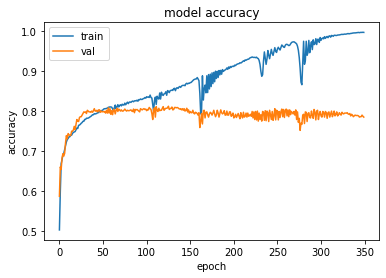

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
y_pred=estimator.predict(X_test)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [15]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.783
F1 score: 0.7814702920443102
Recall: 0.7886178861788617
Precision: 0.7744510978043913

 clasification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       508
           1       0.77      0.79      0.78       492

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


 confussion matrix:
 [[395 113]
 [104 388]]


In [19]:
pred_class = []
for i in range(len(y_pred)):
    pred_class.append(y_pred[i][0])

In [20]:
print(pred_class)

[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 

In [21]:
column_names = ['in', 'Class']
df = pd.DataFrame(columns = column_names)

In [23]:
temp = pd.read_csv('../input/semeval/subtaskA_test_data.csv')
df['in'] = temp['id']
df['Class'] = pred_class

In [24]:
df

,in,Class
0,1175,0
1,452,0
2,275,1
3,869,1
4,50,1
...,...,...
995,1114,1
996,8,1
997,1945,1
998,1053,0


In [ ]:
df.to_csv('subtaskA_answers_use.csv', index = False, header = False)